# 2.2 Passi di analisi progetto base

## Setup

In [6]:
!pip3 install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366441 sha256=f53fa87181e2f1a4fc59835b83890d41df96af970ca9b8ac68e9794c75cb5e18
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [7]:
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import surprise

from google.colab import drive

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

from surprise import accuracy, Dataset, KNNBasic, Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

## 0. Caricamento e organizzazione dei dati

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/project_MIGA/data/100k_a.csv'

df = pd.read_csv(dataset_path, names=['user_id', 'stream_id', 'streamer', 'time_start', 'time_stop'])
df

,user_id,stream_id,streamer,time_start,time_stop
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594
...,...,...,...,...,...
3051728,100000,34167930576,mckytv,3582,3583
3051729,100000,34168288656,natehill,3582,3583
3051730,100000,34169594512,fortnite,3582,3584
3051731,100000,34180223072,highdistortion,3709,3711


### Organizzazione dei dati

In [10]:
df['watchtime'] = df['time_stop'] - df['time_start']
watch_time_max = 6148 # 43days = 6148 step da 10 min

In [11]:
df = df.drop(['time_start', 'time_stop'], axis=1)

df_ratings = df.groupby(['user_id', 'streamer'], as_index = False).sum()
df_ratings = df_ratings.drop('stream_id', axis=1)
df_ratings_big = df_ratings
df_ratings

,user_id,streamer,watchtime
0,1,alptv,3
1,1,berkriptepe,3
2,1,elraenn,2
3,1,eraymaskulen,1
4,1,esl_csgo,1
...,...,...,...
1505153,100000,mckytv,1
1505154,100000,natehill,1
1505155,100000,ninja,3
1505156,100000,replays,1


## 1. Analisi Esplorativa (statistiche descrittive, analisi correlazione)

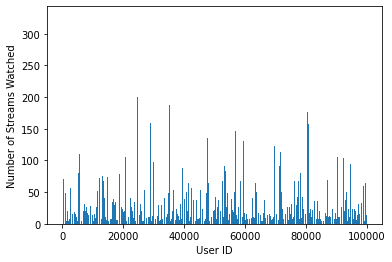

In [11]:
import matplotlib.pyplot as plt

# Group the data by user ID and count the number of streams
stream_count = df.groupby('user_id')['stream_id'].count()

# Create a bar chart of the stream count
plt.bar(stream_count.index, stream_count.values)
plt.xlabel('User ID')
plt.ylabel('Number of Streams Watched')
plt.show()

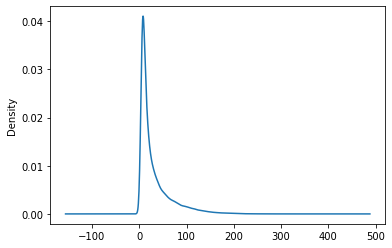

In [12]:
stream_count.plot.density();

In [13]:
stream_count.describe()

count    100000.000000
mean         30.517330
std          34.179094
min           5.000000
25%           8.000000
50%          16.000000
75%          39.000000
max         327.000000
Name: stream_id, dtype: float64

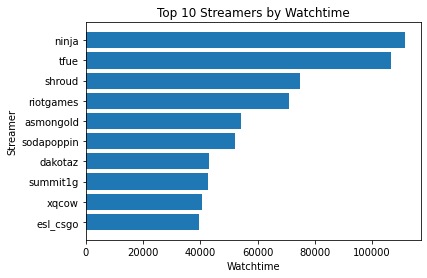

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the DataFrame by streamer and sum the watchtime
streamer_wt = df.groupby('streamer')['watchtime'].sum().sort_values(ascending=False)[:10]

# Create a horizontal bar chart
plt.barh(streamer_wt.index, streamer_wt.values)
plt.gca().invert_yaxis()
plt.title('Top 10 Streamers by Watchtime')
plt.xlabel('Watchtime')
plt.ylabel('Streamer')
plt.show()

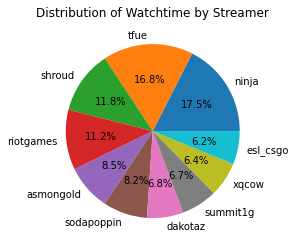

In [15]:
import matplotlib.pyplot as plt

# Group the DataFrame by streamer and sum the watchtime
streamer_wt = df.groupby('streamer')['watchtime'].sum().sort_values(ascending=False)[:10]

# Create a pie chart
plt.pie(streamer_wt.values, labels=streamer_wt.index, autopct='%1.1f%%')
plt.title('Distribution of Watchtime by Streamer')
plt.show()

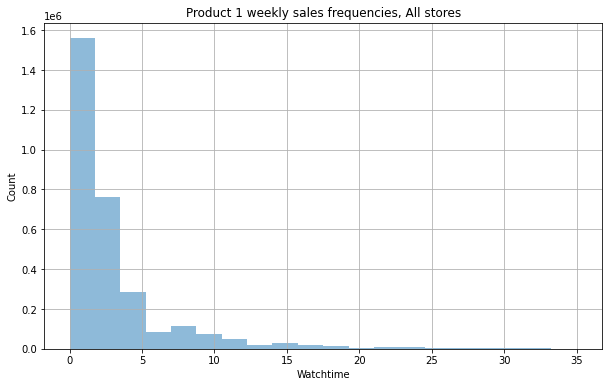

In [17]:
df.watchtime.hist(range=[0, 35], bins=20, alpha=0.5, figsize=(10,6));
plt.title('Product 1 weekly sales frequencies, All stores');
plt.xlabel('Watchtime');
plt.ylabel('Count');

In [18]:
df.isna().sum()

user_id      0
stream_id    0
streamer     0
watchtime    0
dtype: int64

In [19]:
df.watchtime.describe()

count    3.051733e+06
mean     3.142054e+00
std      4.257966e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      9.700000e+01
Name: watchtime, dtype: float64

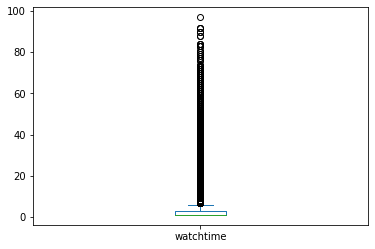

In [20]:
df.watchtime.plot.box()

## 2. Identificazione della configurazione ottimale dell’algoritmo K-NN per la predizione dei rating.
In questo punto dovranno quindi essere testate le diverse combinazioni di:

*   distanza
*   valore di K
*   user/item based

Tramite le diverse metriche di performance (MSE e RMSE) individuare di conseguenza la configurazione ottimale. 

### Elaborazione del dataframe

In [14]:
user_counts = df_ratings.groupby('user_id').size().reset_index(name='counts')
user_counts = user_counts.sort_values('counts', ascending=False)
top_1k_users = user_counts.head(1000)
top_1k_users

,user_id,counts
43042,43043,295
50083,50084,198
58336,58337,197
14726,14727,196
15025,15026,196
...,...,...
36931,36932,71
4260,4261,71
99465,99466,71
12357,12358,70


In [15]:
top_users_entries = df_ratings[df_ratings['user_id'].isin(top_1k_users['user_id'])]
top_users_entries

,user_id,streamer,watchtime
686,55,amouranth,1
687,55,antilipsi,24
688,55,aphromoo,1
689,55,athanashs,4
690,55,avelline_,6
...,...,...,...
1504903,99981,werlyb,3
1504904,99981,wismichu,1
1504905,99981,xmataa,2
1504906,99981,yassuo,13


In [16]:
# counts = number of user that view streamers
streamer_counts = top_users_entries.groupby('streamer').size().reset_index(name='counts')
streamer_counts = streamer_counts.sort_values('counts', ascending=False)
top_1k_streamer = streamer_counts.head(1000)
top_1k_streamer

,streamer,counts
28911,shroud,363
22818,ninja,296
31687,tfue,267
29760,sodapoppin,266
30741,summit1g,212
...,...,...
19989,maxalibur,11
13795,imnio,11
24352,parasite,11
3654,blooddiamondtv,11


In [17]:
top_streamer_entries = top_users_entries[top_users_entries['streamer'].isin(top_1k_streamer['streamer'])]
top_streamer_entries

,user_id,streamer,watchtime
686,55,amouranth,1
688,55,aphromoo,1
692,55,chaseshaco,1
693,55,cowsep,1
696,55,disguisedtoast,2
...,...,...,...
1504897,99981,tarzaned,7
1504898,99981,tfblade,9
1504899,99981,th3antonio,1
1504900,99981,tipsoutbaby,1


### Identificazione della configurazione ottimale dell’algoritmo K-NN

#### Analiticamente

In [18]:
df_ratings = top_streamer_entries

# Convert the pandas DataFrame into surprise dataset format
reader = Reader(rating_scale=(0, watch_time_max))
dataset_surprise = Dataset.load_from_df(df_ratings[['user_id', 'streamer', 'watchtime']], reader)

In [26]:
# Compute error with different values of K
mse_over_k, rmse_over_k = [], []

for k in np.arange(1, 50, 1):
  print(f'Trying k={k}...')
  algo = KNNBasic(k=k, verbose=False)
  kfold_result_knn = cross_validate(algo, dataset_surprise, cv=10, measures=['mse', 'rmse'], verbose=False)
  
  # print(f"- {kfold_result['test_mse'].mean()}")
  # print(f"- {kfold_result['test_rmse'].mean()}")
  
  mse_over_k.append(kfold_result_knn['test_mse'].mean())
  rmse_over_k.append(kfold_result_knn['test_rmse'].mean())

Trying k=1...
Trying k=2...
Trying k=3...
Trying k=4...
Trying k=5...
Trying k=6...
Trying k=7...
Trying k=8...
Trying k=9...
Trying k=10...
Trying k=11...
Trying k=12...
Trying k=13...
Trying k=14...
Trying k=15...
Trying k=16...
Trying k=17...
Trying k=18...
Trying k=19...
Trying k=20...
Trying k=21...
Trying k=22...
Trying k=23...
Trying k=24...
Trying k=25...
Trying k=26...
Trying k=27...
Trying k=28...
Trying k=29...
Trying k=30...
Trying k=31...
Trying k=32...
Trying k=33...
Trying k=34...
Trying k=35...
Trying k=36...
Trying k=37...
Trying k=38...
Trying k=39...
Trying k=40...
Trying k=41...
Trying k=42...
Trying k=43...
Trying k=44...
Trying k=45...
Trying k=46...
Trying k=47...
Trying k=48...
Trying k=49...


Best k = 46 -> 130.4285036916798


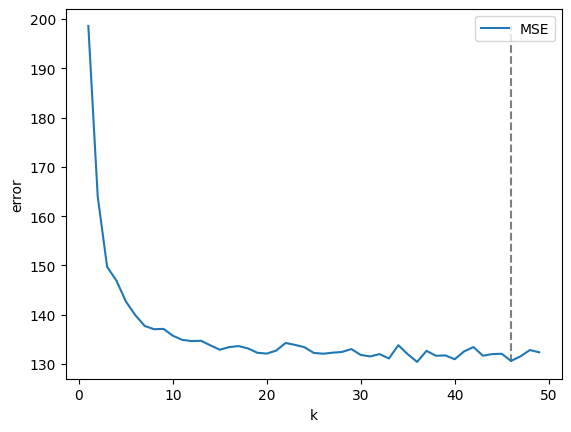

In [27]:
ks = np.arange(1, 50, 1)
plt.style.use('default')
print(f'Best k = {ks[np.argmin(rmse_over_k)]} -> {np.min(mse_over_k)}')
plt.plot(ks, mse_over_k, label='MSE')
plt.vlines(x=ks[np.argmin(rmse_over_k)], ymin=np.min(mse_over_k), ymax=np.max(mse_over_k),
           linestyle='--', color='grey')
plt.xlabel('k')
plt.ylabel('error')
plt.legend()

Best k = 46 -> 11.394723994056296


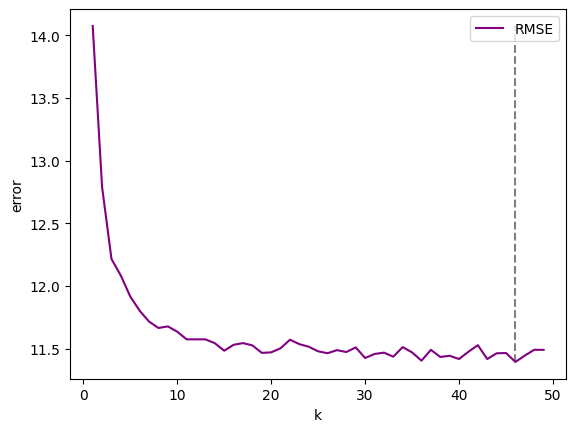

In [28]:
ks = np.arange(1, 50, 1)
plt.style.use('default')
print(f'Best k = {ks[np.argmin(rmse_over_k)]} -> {np.min(rmse_over_k)}')
plt.plot(ks, rmse_over_k, label='RMSE', color='purple')
plt.vlines(x=ks[np.argmin(rmse_over_k)], ymin=np.min(rmse_over_k), ymax=np.max(rmse_over_k),
           linestyle='--', color='grey')
plt.xlabel('k')
plt.ylabel('error')
plt.legend()

#### Grid Search

In [29]:
# Define the grid of parameters (this depends on the algorithms)
k_list = range(1,50)
param_grid = {
    'k': k_list,
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False],
    },
}
# Initialize and train the Grid Search
gs = GridSearchCV(KNNBasic, param_grid, measures=["rmse", "mse"], cv=10, n_jobs=-1)
gs.fit(dataset_surprise)

In [30]:
# best RMSE score
print(f'Best MSE = {gs.best_score["mse"]:.4f}')
print(f'Best RMSE = {gs.best_score["rmse"]:.4f}')
# combination of parameters that gave the best RMSE score
print(f'Best configuration = {gs.best_params["rmse"]}')

Best MSE = 117.8646
Best RMSE = 10.8330
Best configuration = {'k': 49, 'sim_options': {'name': 'cosine', 'user_based': True}}


### Definizione del KNN con la configurazione ottimale

In [31]:
# Getting the best k
ks = np.arange(1, 50, 1)
best_k = ks[np.argmin(rmse_over_k)]

# Creating the KNN with best k
best_algo = KNNBasic(k=best_k, verbose=False)

# Fitting the entaire dataset
trainset = dataset_surprise.build_full_trainset()
best_algo.fit(trainset)

kfold_result_knn = cross_validate(best_algo, dataset_surprise, measures=['RMSE', 'MSE'], cv=10, verbose=True)

Evaluating RMSE, MSE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    9.9960  12.4893 12.1870 11.5027 10.9152 12.0105 10.7337 12.5490 11.1276 10.7008 11.4212 0.8196  
MSE (testset)     99.9208 155.9823148.5223132.3124119.1421144.2514115.2119157.4776123.8236114.5067131.115118.6781 
Fit time          0.03    0.04    0.03    0.05    0.04    0.05    0.05    0.04    0.03    0.04    0.04    0.01    
Test time         0.16    0.15    0.17    0.16    0.16    0.16    0.15    0.16    0.16    0.16    0.16    0.01    


## 3. Filling della matrice di rating con la configurazione ottimale

In [22]:
df_pivot = df_ratings.pivot(index='user_id', columns='streamer', values='watchtime')
df_pivot = df_pivot.fillna(0)
df_pivot

streamer,10000days,1adrianaries1,2sick4drama,2tango4mario,3lekzender,404brokenblade,72hrs,a1taoda,a_seagull,abadonblack,...,zeon,zerator,zero,zeusidiouss,ziggy,zillacamo,ziqoftw,zizaran,zmokamok,zsonicfox
user_id,,,,,,,,,,,,,,,,,,,,,
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
99622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0
99776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,8.0,0.0,0.0


In [49]:
df_pivot.isna().sum()

streamer
10000days        0
1adrianaries1    0
2sick4drama      0
2tango4mario     0
3lekzender       0
                ..
zillacamo        0
ziqoftw          0
zizaran          0
zmokamok         0
zsonicfox        0
Length: 1000, dtype: int64

In [34]:
# Get the shape of the original rating matrix
n_users, n_items = df_pivot.shape

predicted_ratings = pd.DataFrame()

# Iterate through all the user-item pairs
for user_id, row in df_pivot.iterrows():
  for streamer in row.index:

    # Use the KNN algorithm to predict the rating
    prediction = best_algo.predict(user_id, streamer, verbose=True)

    # Insert the predicted rating into the new matrix
    predicted_ratings.at[user_id, streamer] = prediction.est
    
    # print(f"- Predizione: [user: {user_id}, streamer: {streamer}] -> {prediction.est}")

user: 55         item: 10000days  r_ui = None   est = 9.39   {'actual_k': 9, 'was_impossible': False}
user: 55         item: 1adrianaries1 r_ui = None   est = 2.57   {'actual_k': 15, 'was_impossible': False}
user: 55         item: 2sick4drama r_ui = None   est = 1.21   {'actual_k': 2, 'was_impossible': False}
user: 55         item: 2tango4mario r_ui = None   est = 6.35   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 55         item: 3lekzender r_ui = None   est = 6.35   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 55         item: 404brokenblade r_ui = None   est = 2.35   {'actual_k': 19, 'was_impossible': False}
user: 55         item: 72hrs      r_ui = None   est = 16.48   {'actual_k': 27, 'was_impossible': False}
user: 55         item: a1taoda    r_ui = None   est = 8.55   {'actual_k': 3, 'was_impossible': False}
user: 55         item: a_seagull  r_ui = None   est = 2.72   {'actual_k': 22, 'was_impossible': False}
user: 55         item: abadon

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


Streaming output truncated to the last 5000 lines.
user: 99617      item: 10000days  r_ui = None   est = 4.22   {'actual_k': 13, 'was_impossible': False}
user: 99617      item: 1adrianaries1 r_ui = None   est = 2.76   {'actual_k': 10, 'was_impossible': False}
user: 99617      item: 2sick4drama r_ui = None   est = 2.25   {'actual_k': 6, 'was_impossible': False}
user: 99617      item: 2tango4mario r_ui = None   est = 6.35   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 99617      item: 3lekzender r_ui = None   est = 11.00   {'actual_k': 1, 'was_impossible': False}
user: 99617      item: 404brokenblade r_ui = None   est = 2.45   {'actual_k': 16, 'was_impossible': False}
user: 99617      item: 72hrs      r_ui = None   est = 4.56   {'actual_k': 36, 'was_impossible': False}
user: 99617      item: a1taoda    r_ui = None   est = 4.68   {'actual_k': 7, 'was_impossible': False}
user: 99617      item: a_seagull  r_ui = None   est = 6.00   {'actual_k': 34, 'was_impossible': Fal

In [35]:
predicted_ratings

,10000days,1adrianaries1,2sick4drama,2tango4mario,3lekzender,404brokenblade,72hrs,a1taoda,a_seagull,abadonblack,...,zeon,zerator,zero,zeusidiouss,ziggy,zillacamo,ziqoftw,zizaran,zmokamok,zsonicfox
55,9.385194,2.566395,1.210526,6.347386,6.347386,2.349944,16.476439,8.545455,2.724833,1.714286,...,4.284889,22.879370,3.540146,5.689668,5.067592,6.347386,5.833661,8.378762,5.641284,7.083075
139,4.448304,6.896124,5.553126,6.347386,9.000000,1.615006,4.827413,5.498476,6.925817,6.347386,...,7.348775,32.895056,4.051093,4.571354,8.534873,1.975000,3.013390,3.817238,7.913458,3.280898
353,2.243158,3.202414,3.000000,6.347386,6.347386,3.745229,4.809826,9.106779,7.137410,6.347386,...,2.736670,7.961185,3.321763,2.677799,7.817021,6.347386,5.402224,16.005625,2.448844,4.696762
361,6.347386,6.347386,1.000000,6.347386,6.347386,1.000000,6.347386,11.924658,4.068302,6.347386,...,1.000000,5.000000,6.347386,1.000000,6.347386,6.347386,6.347386,9.866716,6.347386,6.347386
417,12.260629,1.263869,2.480893,6.347386,9.000000,1.544649,4.644892,19.186037,3.020456,6.347386,...,5.874644,30.074719,4.204530,6.379747,5.155556,3.904195,6.519422,6.863166,2.702461,7.298144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99617,4.215902,2.760095,2.249110,6.347386,11.000000,2.445415,4.563681,4.684968,5.999594,2.000000,...,9.221539,10.121415,6.289116,7.132857,8.502764,4.000000,2.651682,6.977145,4.223922,5.151092
99622,2.110763,2.684453,3.403713,6.347386,7.913907,1.894120,4.013683,12.657755,1.724488,1.478081,...,2.358957,14.943086,3.753222,3.557738,4.644516,2.594222,51.825030,7.836995,4.711719,1.659517
99776,2.269146,2.123624,1.012449,6.347386,6.347386,12.046652,8.513938,5.889359,11.018212,1.002729,...,7.444141,4.606429,8.053307,5.505718,5.501757,4.000000,13.908767,6.522293,3.938536,8.934922
99795,6.034409,2.013683,6.347386,6.347386,6.347386,2.374636,3.765531,5.718615,3.922369,6.347386,...,1.664308,4.899732,1.196500,6.374717,12.217188,6.347386,3.425333,4.164427,1.933418,4.912722


## 4. Segmentazione degli utenti in base alle preferenze: algoritmo di clustering K-MEANS con cosine similarity.

### Clustering not working

In [36]:
from sklearn.cluster import KMeans
import seaborn as sns

In [37]:
# Make a copy of the dataframe for clustering
cluster_df = df_ratings[['streamer', 'watchtime']].copy()

# One-hot encode the streamer column
# cluster_df = pd.get_dummies(cluster_df, columns=['streamer'])
cluster_df['streamer'] = cluster_df.streamer.astype('category').cat.codes

# Create an instance of the KMeans model
kmeans = KMeans(n_clusters=10)

# Fit the model to the data
kmeans.fit(cluster_df)

# Get the cluster labels for each streamer
labels = kmeans.predict(cluster_df)

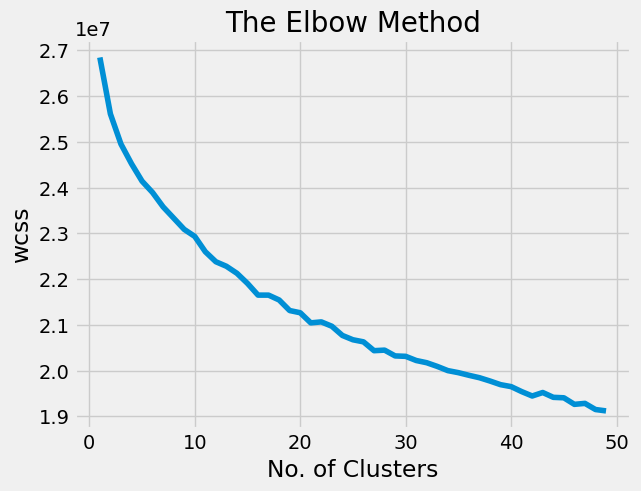

In [38]:
plt.style.use('fivethirtyeight')

wcss = []

for i in range(1, 50):
  km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  km.fit(predicted_ratings)
  wcss.append(km.inertia_)

plt.plot(range(1, 50), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

In [39]:
data= df_pivot

km = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(data)

In [40]:
# plt.figure(figsize=(10,6))
# sns.scatterplot(data = data)
# plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 60, c = 'blue' , label = 'centeroid')
# plt.show();

### Clustering Working

In [69]:
n_streamers_by_user = df_ratings_big.groupby('user_id').size().reset_index(name='n_streamer')
n_streamers_by_user = n_streamers_by_user.sort_values('n_streamer', ascending=False)
n_streamers_by_user

,user_id,n_streamer
43042,43043,295
50083,50084,198
58336,58337,197
14726,14727,196
15025,15026,196
...,...,...
1700,1701,1
57173,57174,1
82032,82033,1
49469,49470,1


In [70]:
streamers_by_user = df_ratings_big.groupby(['user_id','streamer']).sum()
sum_watchtime_by_user = streamers_by_user.groupby('user_id').sum().sort_values('watchtime', ascending=False)
sum_watchtime_by_user

,watchtime
user_id,
84220,1438
14056,1377
99620,1323
45683,1284
80645,1217
...,...
43723,5
4262,5
88131,5


In [71]:
streamer_and_time_cluster_df = pd.merge(n_streamers_by_user, sum_watchtime_by_user, how='left', on='user_id').rename(columns = {'watchtime':'tot_watchtime'})
streamer_and_time_cluster_df

,user_id,n_streamer,tot_watchtime
0,43043,295,729
1,50084,198,545
2,58337,197,582
3,14727,196,532
4,15026,196,536
...,...,...,...
99995,1701,1,9
99996,57174,1,38
99997,82033,1,8
99998,49470,1,22


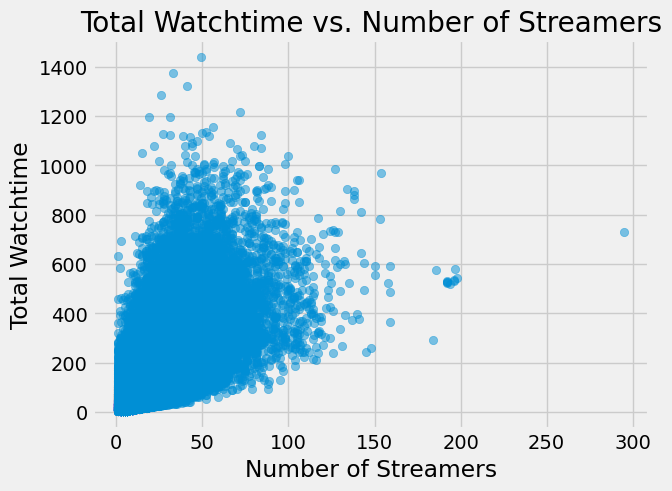

In [72]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(streamer_and_time_cluster_df['n_streamer'], streamer_and_time_cluster_df['tot_watchtime'], alpha=0.5)

# Add title and labels
plt.title('Total Watchtime vs. Number of Streamers')
plt.xlabel('Number of Streamers')
plt.ylabel('Total Watchtime')
plt.show()


In [73]:
streamer_and_time_cluster_df.describe()

,user_id,n_streamer,tot_watchtime
count,100000.000000,100000.000000,100000.000000
mean,50000.500000,15.051580,95.887110
std,28867.657797,14.780537,127.872463
min,1.000000,1.000000,5.000000
25%,25000.750000,5.000000,19.000000
50%,50000.500000,10.000000,45.000000
75%,75000.250000,19.000000,116.000000
max,100000.000000,295.000000,1438.000000


In [74]:
data = streamer_and_time_cluster_df

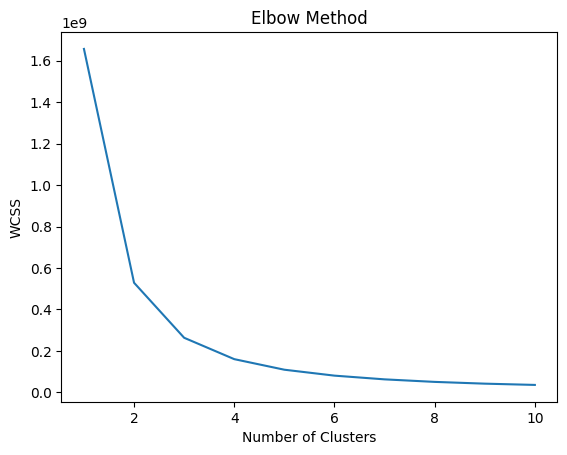

In [75]:
# Prepare the data for clustering
X = data[['n_streamer', 'tot_watchtime']].values

# Compute the within-cluster sum of squares (WCSS) for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the WCSS for different values of k
plt.style.use('default')
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

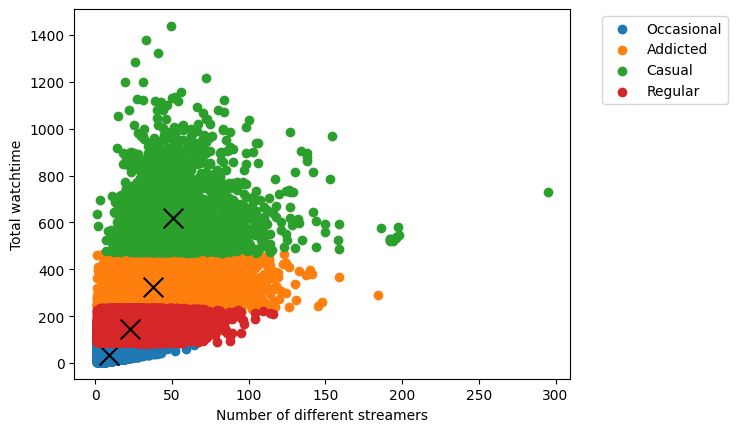

In [76]:
# Select the features to use for clustering
X = data[['n_streamer', 'tot_watchtime']]

labels = ['Occasional', 'Addicted', 'Casual','Regular' ]

# Set the number of clusters
kmeans = KMeans(n_clusters=4)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels and add them to the original dataframe
data['cluster'] = kmeans.labels_

# Assign labels to each cluster based on summary statistics
cluster_labels = {}
for i in range(kmeans.n_clusters):
    cluster = data[data['cluster'] == i]
    n_streamer_mean = cluster['n_streamer'].mean()
    tot_watchtime_mean = cluster['tot_watchtime'].mean()
    label = labels[i]
    cluster_labels[i] = label

# Create a scatter plot of the data, colored by cluster
fig, ax = plt.subplots()
for cluster, group in data.groupby('cluster'):
    ax.scatter(group['n_streamer'], group['tot_watchtime'], label=cluster_labels[cluster])
    centroid = kmeans.cluster_centers_[cluster]
    ax.scatter(centroid[0], centroid[1], s=200, marker='x', color='black')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of different streamers')
plt.ylabel('Total watchtime')
plt.show()

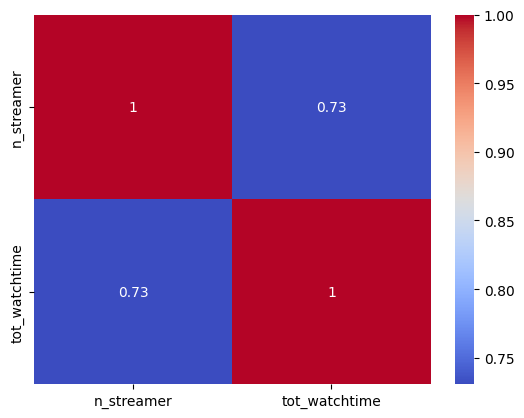

In [77]:
# Load the dataframe
df = data

# Compute the correlation matrix
corr_matrix = df[['n_streamer', 'tot_watchtime']].corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

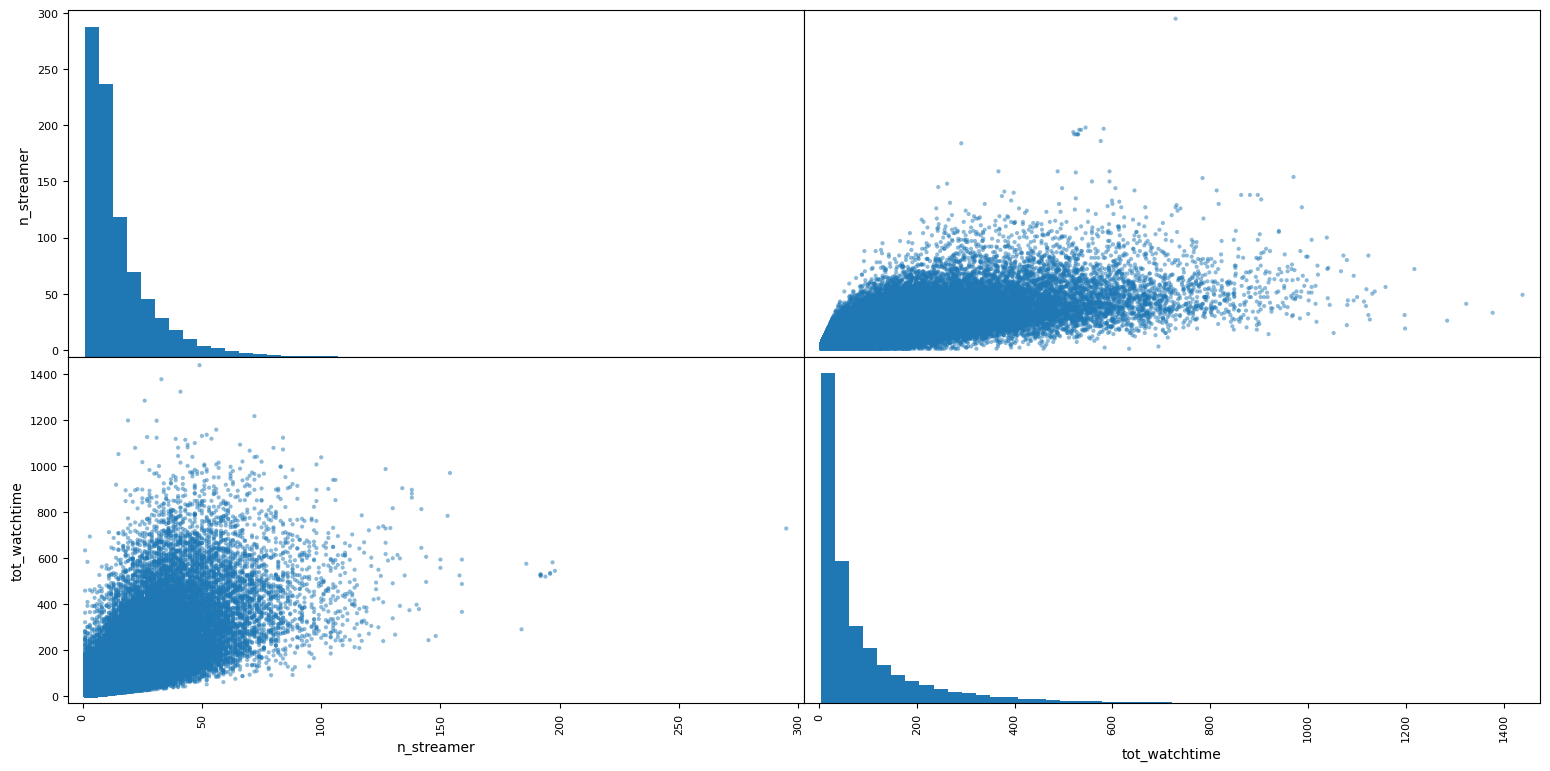

In [78]:
pd.plotting.scatter_matrix(data[['n_streamer', 'tot_watchtime']], alpha=0.5,
                           diagonal = 'hist',
                           hist_kwds={'bins': 50},
                           figsize = (19,9), grid = True);

## 5. Creare per ogni utente la lista degli n items da consigliare (es. considerando il rating predetto).

In [79]:
removed_rated = predicted_ratings.where(df_pivot == 0, -1)
removed_rated

,10000days,1adrianaries1,2sick4drama,2tango4mario,3lekzender,404brokenblade,72hrs,a1taoda,a_seagull,abadonblack,...,zeon,zerator,zero,zeusidiouss,ziggy,zillacamo,ziqoftw,zizaran,zmokamok,zsonicfox
55,9.385194,2.566395,1.210526,6.347386,6.347386,2.349944,16.476439,8.545455,2.724833,1.714286,...,4.284889,22.879370,3.540146,5.689668,5.067592,6.347386,5.833661,8.378762,5.641284,7.083075
139,4.448304,6.896124,5.553126,6.347386,9.000000,1.615006,4.827413,5.498476,6.925817,6.347386,...,7.348775,32.895056,4.051093,4.571354,8.534873,1.975000,3.013390,3.817238,7.913458,3.280898
353,2.243158,3.202414,3.000000,6.347386,6.347386,3.745229,4.809826,9.106779,7.137410,6.347386,...,2.736670,7.961185,3.321763,2.677799,7.817021,6.347386,5.402224,16.005625,2.448844,4.696762
361,6.347386,6.347386,1.000000,6.347386,6.347386,1.000000,6.347386,11.924658,4.068302,6.347386,...,1.000000,5.000000,6.347386,1.000000,6.347386,6.347386,6.347386,9.866716,6.347386,6.347386
417,12.260629,1.263869,2.480893,6.347386,9.000000,1.544649,4.644892,19.186037,3.020456,6.347386,...,5.874644,30.074719,4.204530,6.379747,5.155556,3.904195,6.519422,6.863166,2.702461,7.298144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99617,4.215902,2.760095,2.249110,6.347386,11.000000,2.445415,4.563681,4.684968,5.999594,2.000000,...,-1.000000,10.121415,6.289116,-1.000000,8.502764,4.000000,2.651682,6.977145,4.223922,5.151092
99622,2.110763,2.684453,3.403713,6.347386,7.913907,1.894120,4.013683,12.657755,1.724488,1.478081,...,2.358957,14.943086,3.753222,3.557738,4.644516,2.594222,-1.000000,7.836995,4.711719,1.659517
99776,2.269146,2.123624,1.012449,6.347386,6.347386,12.046652,8.513938,5.889359,11.018212,1.002729,...,7.444141,4.606429,8.053307,5.505718,5.501757,4.000000,-1.000000,-1.000000,3.938536,8.934922
99795,6.034409,2.013683,6.347386,6.347386,6.347386,2.374636,3.765531,5.718615,3.922369,6.347386,...,1.664308,4.899732,1.196500,6.374717,12.217188,6.347386,3.425333,4.164427,1.933418,4.912722


In [80]:
removed_rated = removed_rated.apply(lambda x: x.sort_values(ascending=False), axis=1)
removed_rated

,10000days,1adrianaries1,2sick4drama,2tango4mario,3lekzender,404brokenblade,72hrs,a1taoda,a_seagull,abadonblack,...,zeon,zerator,zero,zeusidiouss,ziggy,zillacamo,ziqoftw,zizaran,zmokamok,zsonicfox
55,9.385194,2.566395,1.210526,6.347386,6.347386,2.349944,16.476439,8.545455,2.724833,1.714286,...,4.284889,22.879370,3.540146,5.689668,5.067592,6.347386,5.833661,8.378762,5.641284,7.083075
139,4.448304,6.896124,5.553126,6.347386,9.000000,1.615006,4.827413,5.498476,6.925817,6.347386,...,7.348775,32.895056,4.051093,4.571354,8.534873,1.975000,3.013390,3.817238,7.913458,3.280898
353,2.243158,3.202414,3.000000,6.347386,6.347386,3.745229,4.809826,9.106779,7.137410,6.347386,...,2.736670,7.961185,3.321763,2.677799,7.817021,6.347386,5.402224,16.005625,2.448844,4.696762
361,6.347386,6.347386,1.000000,6.347386,6.347386,1.000000,6.347386,11.924658,4.068302,6.347386,...,1.000000,5.000000,6.347386,1.000000,6.347386,6.347386,6.347386,9.866716,6.347386,6.347386
417,12.260629,1.263869,2.480893,6.347386,9.000000,1.544649,4.644892,19.186037,3.020456,6.347386,...,5.874644,30.074719,4.204530,6.379747,5.155556,3.904195,6.519422,6.863166,2.702461,7.298144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99617,4.215902,2.760095,2.249110,6.347386,11.000000,2.445415,4.563681,4.684968,5.999594,2.000000,...,-1.000000,10.121415,6.289116,-1.000000,8.502764,4.000000,2.651682,6.977145,4.223922,5.151092
99622,2.110763,2.684453,3.403713,6.347386,7.913907,1.894120,4.013683,12.657755,1.724488,1.478081,...,2.358957,14.943086,3.753222,3.557738,4.644516,2.594222,-1.000000,7.836995,4.711719,1.659517
99776,2.269146,2.123624,1.012449,6.347386,6.347386,12.046652,8.513938,5.889359,11.018212,1.002729,...,7.444141,4.606429,8.053307,5.505718,5.501757,4.000000,-1.000000,-1.000000,3.938536,8.934922
99795,6.034409,2.013683,6.347386,6.347386,6.347386,2.374636,3.765531,5.718615,3.922369,6.347386,...,1.664308,4.899732,1.196500,6.374717,12.217188,6.347386,3.425333,4.164427,1.933418,4.912722


In [81]:
def get_n_suggested_streamers(n):
  i = 0
  suggested_streamers = {}
  
  for user in removed_rated.iterrows():
    # Getting best suggested streamer with name and value
    suggested_streamers[user[0]] = removed_rated.iloc[i].sort_values(ascending=False).head(n).index

    i += 1

  return suggested_streamers

Example

In [82]:
suggested_streamers = get_n_suggested_streamers(5)

## 6. Filling della matrice di rating attraverso Matrix Factorization in aggiunta a K-NN e confronto dei risultati ottenuti in termini di MSE e RMSE.

In [19]:
from surprise import SVD

matrix_factorization = SVD()

# Run 10-fold cross-validation and print results.
kfold_result_mf = cross_validate(matrix_factorization, dataset_surprise, measures=['RMSE', 'MSE'], cv=10, verbose=True)

Evaluating RMSE, MSE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    10.5897 11.1828 11.0637 10.5960 11.3519 10.4851 11.6211 10.4435 10.8070 12.2294 11.0370 0.5467  
MSE (testset)     112.1422125.0551122.4064112.2746128.8663109.9366135.0510109.0675116.7903149.5590122.114912.3208 
Fit time          0.44    0.44    0.43    0.42    0.43    0.43    0.42    0.37    0.34    0.34    0.40    0.04    
Test time         0.02    0.02    0.02    0.02    0.05    0.02    0.02    0.04    0.02    0.02    0.02    0.01    


### Performance comparison

In [84]:
kfold_result_mf['test_mse'] = np.delete(kfold_result_mf['test_mse'], 2)
kfold_result_mf['test_rmse'] = np.delete(kfold_result_mf['test_rmse'], 2)

Matrix Factorization MSE mean: 120.66801412758316
KNN MSE mean: 131.11511526530796



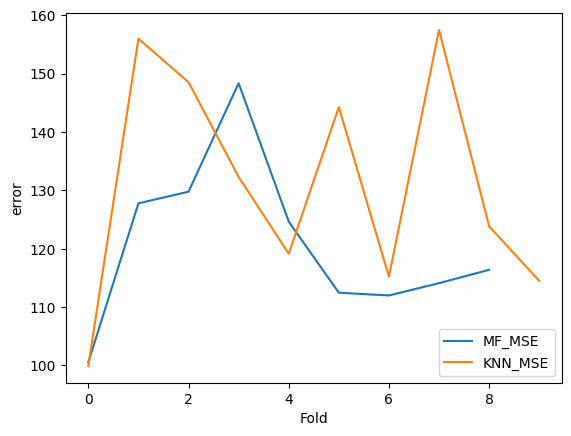

In [85]:
print(f"Matrix Factorization MSE mean: {kfold_result_mf['test_mse'].mean()}")
print(f"KNN MSE mean: {kfold_result_knn['test_mse'].mean()}\n")

plt.style.use('default')
plt.plot(kfold_result_mf['test_mse'], label='MF_MSE')
plt.plot(kfold_result_knn['test_mse'], label='KNN_MSE')
plt.xlabel('Fold')
plt.ylabel('error')
plt.legend();

Matrix Factorization RMSE mean: 10.969311863067142
KNN RMSE mean: 11.42117826517468



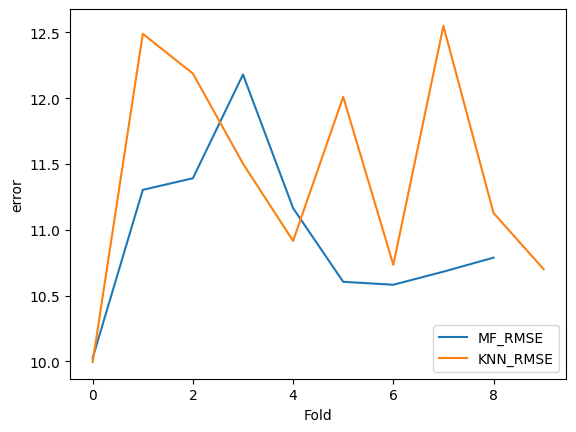

In [86]:
print(f"Matrix Factorization RMSE mean: {kfold_result_mf['test_rmse'].mean()}")
print(f"KNN RMSE mean: {kfold_result_knn['test_rmse'].mean()}\n")

plt.style.use('default')
plt.plot(kfold_result_mf['test_rmse'], label='MF_RMSE')
plt.plot(kfold_result_knn['test_rmse'], label='KNN_RMSE')
plt.xlabel('Fold')
plt.ylabel('error')
plt.legend();

### Filling

In [20]:
# Fitting the entaire dataset
trainset = dataset_surprise.build_full_trainset()
matrix_factorization.fit(trainset)

In [23]:
# Get the shape of the original rating matrix
n_users, n_items = df_pivot.shape

predicted_ratings_mf = pd.DataFrame()

# Iterate through all the user-item pairs
for user_id, row in df_pivot.iterrows():
  for streamer in row.index:
    if df_pivot.at[user_id, streamer] == 0:
      prediction = matrix_factorization.predict(user_id, streamer, verbose=True)

      predicted_ratings_mf.at[user_id, streamer] = prediction.est
    else:
      predicted_ratings_mf.at[user_id, streamer] = df_pivot.at[user_id, streamer]

      # print(f"- Predizione: [user: {user_id}, streamer: {streamer}] -> {prediction.est}")

user: 55         item: 10000days  r_ui = None   est = 4.42   {'was_impossible': False}
user: 55         item: 1adrianaries1 r_ui = None   est = 2.44   {'was_impossible': False}
user: 55         item: 2sick4drama r_ui = None   est = 3.15   {'was_impossible': False}
user: 55         item: 2tango4mario r_ui = None   est = 3.07   {'was_impossible': False}
user: 55         item: 3lekzender r_ui = None   est = 5.15   {'was_impossible': False}
user: 55         item: 404brokenblade r_ui = None   est = 4.84   {'was_impossible': False}
user: 55         item: 72hrs      r_ui = None   est = 7.30   {'was_impossible': False}
user: 55         item: a1taoda    r_ui = None   est = 4.37   {'was_impossible': False}
user: 55         item: a_seagull  r_ui = None   est = 4.40   {'was_impossible': False}
user: 55         item: abadonblack r_ui = None   est = 2.98   {'was_impossible': False}
user: 55         item: aceu       r_ui = None   est = 5.34   {'was_impossible': False}
user: 55         item: adepttheb

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


Streaming output truncated to the last 5000 lines.
user: 99563      item: smoke      r_ui = None   est = 0.93   {'was_impossible': False}
user: 99563      item: snowmixy   r_ui = None   est = 9.37   {'was_impossible': False}
user: 99563      item: snutzy     r_ui = None   est = 4.50   {'was_impossible': False}
user: 99563      item: sodakite   r_ui = None   est = 32.23   {'was_impossible': False}
user: 99563      item: solaaaa    r_ui = None   est = 14.65   {'was_impossible': False}
user: 99563      item: solary     r_ui = None   est = 9.27   {'was_impossible': False}
user: 99563      item: solaryfortnite r_ui = None   est = 15.95   {'was_impossible': False}
user: 99563      item: solidfps   r_ui = None   est = 10.14   {'was_impossible': False}
user: 99563      item: solorenektononly r_ui = None   est = 10.45   {'was_impossible': False}
user: 99563      item: somagreen  r_ui = None   est = 11.77   {'was_impossible': False}
user: 99563      item: sonii      r_ui = None   est = 16.66   {

In [89]:
predicted_ratings_mf

,10000days,1adrianaries1,2sick4drama,2tango4mario,3lekzender,404brokenblade,72hrs,a1taoda,a_seagull,abadonblack,...,zeon,zerator,zero,zeusidiouss,ziggy,zillacamo,ziqoftw,zizaran,zmokamok,zsonicfox
55,4.663679,1.841451,2.635586,3.111277,4.734213,3.540126,3.984538,4.686834,4.761191,2.770104,...,5.315864,10.364297,1.985283,3.738095,5.826786,3.070463,2.620322,5.546339,5.418777,3.504857
139,6.852651,8.706591,3.108038,5.918910,7.942515,7.322602,0.000000,9.006006,2.272573,4.200891,...,6.775547,11.348626,8.179194,6.507510,7.237502,4.888596,0.228135,3.914211,5.695973,7.314525
353,2.897328,1.874266,1.192061,0.937853,3.276845,1.094630,4.151640,1.672524,3.168089,1.741460,...,3.691433,8.175461,2.119547,1.728121,2.631869,2.324182,2.742971,5.302244,4.760707,3.789100
361,6.388551,5.139554,3.739348,4.175108,6.492209,5.313627,2.431557,7.065641,7.745514,4.354963,...,6.628312,9.600084,4.961460,4.840266,7.919395,4.601783,9.236274,3.763347,6.000623,4.350311
417,4.917248,2.125555,2.387594,2.058746,3.380030,4.919819,3.400978,4.312218,3.185938,3.352631,...,4.665455,13.095867,4.642433,3.720041,3.179215,2.251445,6.485720,3.547642,2.075115,1.781313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99617,4.494275,4.558304,4.512508,4.447510,6.507492,2.881400,8.060923,3.087988,7.407476,4.381822,...,10.000000,10.203589,2.662370,8.000000,7.734701,4.159974,3.530495,8.115472,7.282161,4.215317
99622,8.541971,3.579945,6.722580,4.683656,6.567248,11.857615,4.402048,4.572959,0.000000,7.583621,...,7.822948,22.693595,11.971544,7.525774,7.813337,4.367401,54.000000,11.922316,4.919131,6.171491
99776,7.855181,6.843851,7.883349,6.917550,9.270727,10.517115,15.662088,3.426052,11.395349,5.561670,...,4.460927,0.000000,6.663237,8.147454,12.702204,7.098791,15.000000,8.000000,3.185829,2.333126
99795,7.257580,5.470943,9.573403,7.853821,10.869166,5.163896,8.628520,6.952921,9.547008,8.928397,...,7.942171,4.300843,11.417151,5.991114,8.999866,8.863694,8.924174,7.683119,7.109683,3.913288


# 3.2 Passi di analisi progetto intermedio

## Setup

In [1]:
!pip3 install pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 KB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210096 sha256=d4ce15a109c6b8e6ce8a7c620d6b3616d8170bef7b37a98c1cb09a99929d1eb9
  Stored in directory: /root/.cache/pip/wheels/2d/08/6b/126ea9009f7482fd53a78d0db2ece5aca70af8f4a30445386b
Successfully built grapheme


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd

# Algorithms
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA

# Core classes
from pymoo.core.callback import Callback
from pymoo.core.crossover import Crossover
from pymoo.core.evaluator import Evaluator
from pymoo.core.individual import Individual
from pymoo.core.mutation import Mutation
from pymoo.core.population import Population
from pymoo.core.problem import ElementwiseProblem, Problem
from pymoo.core.repair import Repair
from pymoo.core.sampling import Sampling
from pymoo.core.termination import NoTermination

# Performance metrics
from pymoo.indicators.hv import HV

# Genetic operator
from pymoo.operators.crossover.expx import ExponentialCrossover
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.pntx import  PointCrossover, SinglePointCrossover, TwoPointCrossover
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.sampling.rnd import BinaryRandomSampling, FloatRandomSampling
from pymoo.operators.selection.rnd import RandomSelection
from pymoo.operators.selection.tournament import TournamentSelection

# Optimization interface
from pymoo.optimize import minimize

# Problem utilities
from pymoo.problems import get_problem
from pymoo.problems.many.dtlz import DTLZ1
from pymoo.problems.functional import FunctionalProblem
from pymoo.problems.static import StaticProblem

# Operator utilities
from pymoo.operators.repair.rounding import RoundingRepair

# Termination criterion
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination, DefaultSingleObjectiveTermination
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.termination.xtol import DesignSpaceTermination

# General utilities
from pymoo.util import plotting
from pymoo.util.plotting import plot
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.util.remote import Remote

# Plotting utilities
from pymoo.visualization.fitness_landscape import FitnessLandscape
from pymoo.visualization.heatmap import Heatmap
from pymoo.visualization.scatter import Scatter
from pymoo.visualization.petal import Petal
from pymoo.visualization.pcp import PCP
from pymoo.visualization.radar import Radar

## 1. Formulazione del problema multi-obiettivo (accuratezza, novelty e coverage) per creare la lista degli n items da raccomandare per ogni utente.

In [24]:
# Defining variables
n_u = 10 # user to consider
n_i = predicted_ratings_mf.shape[1] # all streamers
k = 3 # suggest 3 streamer

In [25]:
# getting the number of rated items (non 0)
total_rated_streamers = df_pivot.astype(bool).sum(axis=0)
total_rated_streamers

streamer
10000days        14
1adrianaries1    17
2sick4drama      21
2tango4mario     14
3lekzender       21
                 ..
zillacamo        14
ziqoftw          31
zizaran          42
zmokamok         19
zsonicfox        23
Length: 1000, dtype: int64

### Defining metrics

In [26]:
def get_accuracy(suggestions):
    watchtime_sum = 0
    accuracy = 0

    for i in range(0, n_u):
        for j in range(0, n_i):
            watchtime_sum += (predicted_ratings_mf.iat[i, j] * suggestions[i, j]) / df_pivot.iloc[:, j].max()
        accuracy += 1/k * watchtime_sum

    accuracy = accuracy / n_u

    return accuracy

In [27]:
def get_coverage(suggestions):
  bigU = np.array([])
  streamers_list = predicted_ratings_mf.columns

  for i in range(0, n_u):
    for j in range(0, n_i):
          if suggestions[i, j] == 1:
            bigU = np.append(bigU, streamers_list[j])

  # getting unique values
  num_suggested_streamers = len(np.unique(bigU))

  # calculating coverage
  coverage = num_suggested_streamers / n_i

  return coverage

In [28]:
import math

def get_degree(count_rated):
  return math.log2(n_u/count_rated)

streamers_novelty_degree = total_rated_streamers.apply(get_degree)

def get_novelty(suggestions):
  novelty_grade = 0
  streamers_list = predicted_ratings_mf.columns

  for i in range(0, n_u):
    for j in range(0, n_i):
      novelty_grade += streamers_novelty_degree[streamers_list[j]]/k * suggestions[i, j]

  return novelty_grade/n_u

### Defining the problems

In [30]:
# NSGA2 Formulation

class SuggestedList(ElementwiseProblem):
    def __init__(self, n_max):
        tot_user = predicted_ratings_mf.shape[0]
        tot_streamer = predicted_ratings_mf.shape[1]
        tot_entry = tot_user*tot_streamer

        super().__init__(n_var=tot_entry,
                          n_obj=3,
                          n_ieq_constr=1,
                          xl=np.zeros((1, tot_entry)),
                          xu=np.ones((1, tot_entry)))
        
        self.n_max = n_max
        self.tot_user = tot_user
        self.tot_streamer = tot_streamer
        self.tot_entry = tot_entry


    def _evaluate(self, x, out, *args, **kwargs):
      # converto in dataframe
      suggestions = x.reshape(self.tot_user, self.tot_streamer)

      accuracy = get_accuracy(suggestions)
      coverage = get_coverage(suggestions)
      novelty = get_novelty(suggestions)

      # metric * -1 -> Transforming the optimization problem from MAX to MIN
      f1 = accuracy * -1
      f2 = coverage * -1
      f3 = novelty * -1

      h1 = (self.n_max - np.sum(x)) ** 2

      out["F"] = [f1, f2, f3]
      out["G"] = h1

In [31]:
# MOEA/D Formulation

class SuggestedListNoConstraints(ElementwiseProblem):
    def __init__(self, n_max):
        tot_user = n_u
        tot_streamer = n_i
        tot_entry = tot_user*tot_streamer

        super().__init__(n_var=tot_entry,
                          n_obj=3,
                          n_ieq_constr=0,
                          xl=0,
                          xu=1)
        
        self.n_max = k
        self.tot_user = tot_user
        self.tot_streamer = tot_streamer
        self.tot_entry = tot_entry


    def _evaluate(self, x, out, *args, **kwargs):
      # converto in dataframe
      suggestions = x.reshape(self.tot_user, self.tot_streamer)

      accuracy = get_accuracy(suggestions)
      coverage = get_coverage(suggestions)
      novelty = get_novelty(suggestions)

      # metric * -1 -> Transforming the optimization problem from MAX to MIN
      f1 = accuracy * -1
      f2 = coverage * -1
      f3 = novelty * -1

      out["F"] = [f1, f2, f3]

## 2. Risoluzione del problema attraverso gli algoritmi MOEA/D e NSGA-II della libreria Pymoo.

### MOEA/D

#### Operators

In [32]:
class MySampling_MOEAD(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, problem.n_var), False, dtype=bool)

        for k in range(n_samples):
            I = np.random.permutation(problem.n_var)[:problem.n_max]
            X[k, I] = True

        return X


class BinaryCrossover_MOEAD(Crossover):
    def __init__(self):
        super().__init__(2, 1)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape

        _X = np.full((self.n_offsprings, n_matings, problem.n_var), False)

        for k in range(n_matings):
            p1, p2 = X[0, k], X[1, k]

            both_are_true = np.logical_and(p1, p2)
            _X[0, k, both_are_true] = True

            n_remaining = problem.n_max - np.sum(both_are_true)

            I = np.where(np.logical_xor(p1, p2))[0]

            S = I[np.random.permutation(len(I))][:n_remaining]
            _X[0, k, S] = True

        return _X


class MyMutation_MOEAD(Mutation):
    def _do(self, problem, X, **kwargs):
        for i in range(X.shape[0]):
            X[i, :] = X[i, :]
            is_false = np.where(np.logical_not(X[i, :]))[0]
            is_true = np.where(X[i, :])[0]
            X[i, np.random.choice(is_false)] = True
            X[i, np.random.choice(is_true)] = False

        return X

#### Algorithm

In [33]:
# In this case (M=3, p=12) -> n=91
# uniform -> cerca di spaziare uniformemente i vettori
# n_partition -> numero di sottoproblemi

# la dimensione della popolazione iniziale viene derivata dalle reference_direcetions
ref_dirs = get_reference_directions("uniform", 3, n_partitions=12)

problem = SuggestedListNoConstraints(k)

algorithm = MOEAD(
    ref_dirs,
    n_neighbors=15, # vicini da considerare poiché ogni problema deriva anche i vicini derivanti dagli altri problemi
    prob_neighbor_mating=0.7, # prob. che i vicini si cominino tra loro
    sampling=MySampling_MOEAD(), # metodi custom per il sampling
    crossover=BinaryCrossover_MOEAD(), # metodi custom di crossover
    mutation=MyMutation_MOEAD(), # idem per la mutation
)

from datetime import datetime
dateTimeObj = datetime.now()
print(f"# START: {dateTimeObj}\n")

res_MOEAD = minimize(problem,
               algorithm,
               ('n_gen', 20),
               seed=1,
               verbose=True,
               save_history=True)

dateTimeObj = datetime.now()
print(f"\n # END: {dateTimeObj}")

# START: 2023-02-19 21:26:26.649238

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      4 |             - |             -
     2 |      182 |     36 |  1.6613694361 |         ideal
     3 |      273 |     46 |  0.7077957023 |         ideal
     4 |      364 |     31 |  1.0073678917 |         ideal
     5 |      455 |     57 |  0.7063541341 |         ideal
     6 |      546 |     28 |  0.4743131002 |         ideal
     7 |      637 |     35 |  0.5397715955 |         ideal
     8 |      728 |     28 |  0.000000E+00 |             f
     9 |      819 |     31 |  0.5806899375 |         ideal
    10 |      910 |     26 |  2.5941072062 |         ideal
    11 |     1001 |     27 |  0.5075928219 |         ideal
    12 |     1092 |     27 |  0.000000E+00 |             f
    13 |     1183 |     39 |  0.9451172735 |         ideal
    14 |     1274 |     39 |  0.000000E+00 |             f
    15 |     1365 |     30 |  0.5441181910 |         ideal
    16 |     1456 |

### NSGA-II

#### Operators

In [34]:
class MySampling_NSGA2(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, problem.n_var), False, dtype=bool)

        for k in range(n_samples):
            I = np.random.permutation(problem.n_var)[:problem.n_max]
            X[k, I] = True

        return X


class BinaryCrossover_NSGA2(Crossover):
    def __init__(self):
        super().__init__(2, 1)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape

        _X = np.full((self.n_offsprings, n_matings, problem.n_var), False)

        for k in range(n_matings):
            p1, p2 = X[0, k], X[1, k]

            both_are_true = np.logical_and(p1, p2)
            _X[0, k, both_are_true] = True

            n_remaining = problem.n_max - np.sum(both_are_true)

            I = np.where(np.logical_xor(p1, p2))[0]

            S = I[np.random.permutation(len(I))][:n_remaining]
            _X[0, k, S] = True

        return _X


class MyMutation_NSGA2(Mutation):
    def _do(self, problem, X, **kwargs):
        for i in range(X.shape[0]):
            X[i, :] = X[i, :]
            is_false = np.where(np.logical_not(X[i, :]))[0]
            is_true = np.where(X[i, :])[0]
            X[i, np.random.choice(is_false)] = True
            X[i, np.random.choice(is_true)] = False

        return X

#### Algorithm

In [ ]:
problem = SuggestedList(k)

algorithm_NSGA2 = NSGA2(pop_size=100,
                  sampling=MySampling_NSGA2(), 
                  crossover=BinaryCrossover_NSGA2(), 
                  mutation=MyMutation_NSGA2(), 
                  eliminate_duplicates=True)

from datetime import datetime
dateTimeObj = datetime.now()
print(f"# START: {dateTimeObj}\n")

res_NSGA2 = minimize(problem,
               algorithm_NSGA2,
               ('n_gen', 20),
               pf=True,
               seed=1,
               verbose=True)

print(res_NSGA2.algorithm.n_gen)

dateTimeObj = datetime.now()
print(f"\n # END: {dateTimeObj}")

# START: 2023-02-19 22:24:22.328378

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |    100 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |    100 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     3 |      300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.6050635856 |         ideal
     4 |      400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.8023662462 |         ideal
     5 |      500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0012529257 |             f
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0012529257 |             f
    10 |     1000 |    100 |  0.000000E+00 |  0.00000

## 3. Confronto dei risultati ottenuti dai due algoritmi attraverso l’analisi delle metriche di performance quali Hypervolume, C-metric.

In [ ]:
NSGA2 = res_NSGA2.pop.get("F")
MOEAD = res_MOEAD.pop.get("F")

In [ ]:
# Hypervolume

ref_point = np.array([1.2, 1.2, 1.2])

ind = HV(ref_point=ref_point)
print("Hypervolume of approximated NSGA2 Pareto Front: ", ind(NSGA2))
print("Hypervolume of approximated MOEAD Pareto Front: ", ind(MOEAD))

### C-metric

In [ ]:
def is_dominated(sol, pf):
  for point in pf:
    if all(point <= sol) and any(point < sol):
      return True
  return False

def coverage(pf1, pf2):
  dominated = [is_dominated(point, pf1) for point in pf2]
  return sum(dominated) / len(dominated)

In [ ]:
print(f"Coverage(NSGA2, MOEAD) = {coverage(NSGA2, MOEAD)}")
print(f"Coverage(MOEAD, NSGA2) = {coverage(MOEAD, NSGA2)}\n")

## 4. Visualizzazione delle frontiere Paretiane.

In [ ]:
Scatter(legend=True).add(NSGA2, label="Soluzione NSGA-II").add(MOEAD, label="Soluzione MOEA/D").show()